**2D nonlinear diffusion-reaction system**

In [214]:
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
from sys import stderr
from scipy import stats
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.interpolate import griddata
from matplotlib.pyplot import scatter, figure
from torch.utils.data import TensorDataset, DataLoader

seed = 10
batch_size = 500
noise_scale = 0.1
num_samples = 1000
num_sensors = 32

np.random.seed(seed)
torch.manual_seed(seed)

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(4, 4)})
sns.set_style("whitegrid")

class Experiment(nn.Module):
    def __init__(self):
        super(Experiment, self).__init__()

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
        print(self.device)

        self.optimizer = None
        self.train_loss_history = []
        self.w_int = 1
        self.w_data = 1
        self.w_bc = 1
        self.w_param_std = 1
        self.numInputs = 1
        self.numParams = 1
        self.numOutputs = 1
        self.hidden_size = 200

        # Initialize history variables
        self.total_loss_history = []
        self.loss_interior_history = []
        self.loss_data_history = []
        self.loss_bc_history = []
        self.loss_std_history = []

        self.predicted_params = torch.zeros((batch_size,self.numParams), requires_grad=True, device=self.device)
        self.mean_predicted_params = torch.zeros((self.numParams), requires_grad=True, device=self.device)

        # We have 2 input feature
        self.b1 = nn.Linear(self.numInputs, self.hidden_size).to(self.device)
        self.b2 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.b3 = nn.Linear(self.hidden_size, self.numOutputs).to(self.device)

        self.t1 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.t2 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.t3 = nn.Linear(self.hidden_size, self.numParams).to(self.device)
        self.act = nn.ELU()


    def create_dataset(self, noise_scale=0.01, num_samples=16):
        
        # Generate x and y points evenly spaced between -1 and 1
        x1 = torch.linspace(-0.8, -0.2, num_samples, device=self.device)  
        x2 = torch.linspace(0.2, 0.8, num_samples, device=self.device)

        self.sensor_x = torch.cat([x1, x2]).requires_grad_(True)
        # self.sensor_x = torch.linspace(-1, 1, num_samples, device=self.device).requires_grad_(True)
        self.sensor_u = exact_solution(self.sensor_x) + torch.randn(self.sensor_x.shape[0], device=self.device) * noise_scale


    def forward(self, x):
        # if not torch.is_tensor(x):
        #     x = torch.from_numpy(x).float().to(self.device)


        # Add a dimension if it's not already there
        x = x.unsqueeze(1) if x.dim() == 1 else x


        h1 = self.act(self.b1(x))
        h2 = self.act(self.b2(h1))

        prior_param_sample = torch.rand(x.shape[0], self.hidden_size , device=self.device).requires_grad_(True)

        t1 = self.act(self.t1(prior_param_sample))
        t2 = self.act(self.t2(t1))
        posterior_param_sample = self.t3(t2)
        self.predicted_params = posterior_param_sample

        u = self.b3(torch.multiply(t2, h2))
        # u = self.b3(h2)

        return u


    # General formula to compute the n-th order derivative of y = f(x) with respect to x
    def compute_derivative(self, y, x, n):
        if n == 0:
            return y
        else:
            dy_dx = torch.autograd.grad(y, x, torch.ones_like(y, device= self.device),
                                        create_graph=True, retain_graph=True,
                                        allow_unused=True)[0]
        return self.compute_derivative(dy_dx, x, n - 1)


    def PDE_residual(self, x):
        u = self.forward(x)
        # residual = lambda(d2u_dx2 + d2u_dy2) + k * (u**2) + f
        residual = u - torch.pow(torch.sin(self.predicted_params * x), 3)
        return residual


    
    def loss_interior(self, num_samples=500):
        interior_x_samples = 2*torch.rand((num_samples, 1), device=self.device).requires_grad_(True)  - 1.0
        res1 = self.PDE_residual(interior_x_samples)
        loss_residual1 = torch.mean(torch.square(res1))
        return loss_residual1 


    def loss_data(self):
        u_pred = self.forward(self.sensor_x)
        error = torch.square(u_pred.squeeze() - self.sensor_u)
        loss_u = torch.mean(error)
        return loss_u

    def compute_losses(self):
        loss_interior = self.loss_interior()
        loss_data = self.loss_data()
        return loss_interior, loss_data


    def sample_parameter_posterior(self, num_samples=500):
        prior_param_samples = torch.rand(num_samples, self.hidden_size, device=self.device).requires_grad_(True)
        t1 = torch.tanh(self.t1(prior_param_samples))
        t2 = torch.tanh(self.t2(t1))
        posterior_param_samples = self.t3(t2)
        return posterior_param_samples


    def update_predicted_params(self, posterior_samples):
        mean = torch.mean(posterior_samples, dim=0)  # Compute the mean along the first axis
        std = torch.std(posterior_samples, dim=0)    # Compute the standard deviation along the first axis

        self.predicted_params = posterior_samples
        self.mean_predicted_params = mean  # Store the mean
        self.std_params = std  # Attach the standard deviation as an attribute


    def closure(self):
        self.optimizer.zero_grad()
        loss_interior, loss_data = self.compute_losses()
        total_loss = self.w_int * loss_interior \
                    + self.w_data * loss_data 


        # Sample the parameter posterior and update self.predicted_params and self.std_params
        posterior_samples = self.sample_parameter_posterior(num_samples=100)
        self.update_predicted_params(posterior_samples)

        # Add the (Log(std))**2 term to the loss with the specified weight
        # Add the (Log(w * std))**2 term to the loss with the specified weight
        self.log_std_squared_loss = torch.mean(torch.log(self.w_param_std * self.std_params)**2)
        total_loss += self.log_std_squared_loss

        total_loss.backward(retain_graph=True)

        
        return total_loss


    def train(self, epochs, optimizer='Adam', **kwargs):
        if optimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), **kwargs)

        elif optimizer == 'L-BFGS':
            self.optimizer = torch.optim.LBFGS(self.parameters(), **kwargs)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=10, verbose=True)


        # Training loop
#         for epoch in range(epochs):
        for epoch in tqdm(range(epochs), desc="Training Progress", unit="epoch"):
            self.optimizer.step(self.closure)
            if epoch % 200 == 0:
                loss_interior, loss_data = self.compute_losses()
                
                total_loss =  loss_data  

                scheduler.step(total_loss)

                # Append losses to history
                self.total_loss_history.append(total_loss.item())
                self.loss_interior_history.append(loss_interior.item())
                self.loss_data_history.append(loss_data.item())
                self.loss_std_history.append(self.log_std_squared_loss.item())

                print(f'Epoch({optimizer}):{epoch},  Total Loss:{total_loss.item():g}  ' \
                        f'PDE Loss:{loss_interior.item():.4f}  ' \
                        f'Data Loss: {loss_data.item():.4f}  ' \
                        f'Mean Predicted Param 1: {self.mean_predicted_params[0]:.4f} ' \
                        f'Std Params:{self.std_params.detach().cpu().numpy()[0]:.4f}  ' \
                        f'Std Log Loss:{self.log_std_squared_loss.item():.4f}')

In [215]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [216]:
# exact solution
def exact_solution(x):
    return torch.pow(torch.sin(6.0 * x),3)

In [217]:
def make_plot(model, device=device):
    # Generate test data
    num_test_samples = 100
    x_test = torch.linspace(-1, 1, num_test_samples, device=device).unsqueeze(1)
    

    model.eval()
    with torch.no_grad():
        u_preds = model.forward(x_test)
  
    # Compute the exact solutions for comparison
    u_exact = exact_solution(x_test)

    # Create plots
    

    fig, ax = plt.subplots()

    
    # Plot predicted 'u'
    ax.plot(x_test.cpu().numpy(),u_preds.cpu().numpy(), label='Predicted')
    # Plot exact 'u'
    ax.plot(x_test.cpu().numpy(), u_exact.cpu().numpy(), label='Exact')
    ax.plot(model.sensor_x.cpu().detach().numpy(), model.sensor_u.cpu().detach().numpy(), 'o', alpha=0.5, label='Data')


    plt.tight_layout()
    # plt.savefig('result_plot.png', dpi=400)  # Save the figure as a PNG file with 400 DPI
    plt.legend()
    plt.show()
    return ax

In [218]:
net = Experiment()
net.to(net.device)
print("Params:", sum(p.numel() for p in net.parameters() if p.requires_grad))

mps
Params: 121402


In [219]:
net.create_dataset(num_samples=32)

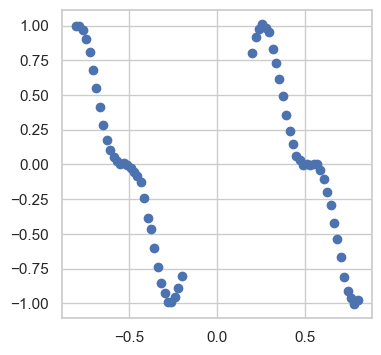

In [220]:
plt.plot(net.sensor_x.cpu().detach().numpy(), net.sensor_u.cpu().detach().numpy(), 'o')

In [359]:
net.w_int = 100
net.w_data = 1000
net.w_bc   = 0
net.w_param_std = 0.1

In [364]:
torch.autograd.set_detect_anomaly(True)
net.train(35000, optimizer='Adam', lr=1e-4)

Training Progress:   0%|          | 5/35000 [00:00<27:23, 21.29epoch/s]

Epoch(Adam):0,  Total Loss:0.034471  PDE Loss:0.2825  Data Loss: 0.0345  Mean Predicted Param 1: 22.0182 Std Params:9.8958  Std Log Loss:0.0001


Training Progress:   1%|          | 206/35000 [00:08<23:15, 24.92epoch/s]

Epoch(Adam):200,  Total Loss:0.00439956  PDE Loss:0.2642  Data Loss: 0.0044  Mean Predicted Param 1: 23.3016 Std Params:9.7990  Std Log Loss:0.0004


Training Progress:   1%|          | 404/35000 [00:16<22:54, 25.17epoch/s]

Epoch(Adam):400,  Total Loss:0.00426571  PDE Loss:0.2260  Data Loss: 0.0043  Mean Predicted Param 1: 22.8750 Std Params:10.1733  Std Log Loss:0.0003


Training Progress:   2%|▏         | 605/35000 [00:23<22:54, 25.03epoch/s]

Epoch(Adam):600,  Total Loss:0.00406558  PDE Loss:0.2226  Data Loss: 0.0041  Mean Predicted Param 1: 22.1744 Std Params:10.5919  Std Log Loss:0.0033


Training Progress:   2%|▏         | 806/35000 [00:31<23:15, 24.50epoch/s]

Epoch(Adam):800,  Total Loss:0.00383719  PDE Loss:0.2415  Data Loss: 0.0038  Mean Predicted Param 1: 23.4090 Std Params:9.4949  Std Log Loss:0.0027


Training Progress:   3%|▎         | 1004/35000 [00:39<22:38, 25.03epoch/s]

Epoch(Adam):1000,  Total Loss:0.00417835  PDE Loss:0.2439  Data Loss: 0.0042  Mean Predicted Param 1: 22.0658 Std Params:9.8366  Std Log Loss:0.0003


Training Progress:   3%|▎         | 1205/35000 [00:47<22:11, 25.38epoch/s]

Epoch(Adam):1200,  Total Loss:0.00366955  PDE Loss:0.2511  Data Loss: 0.0037  Mean Predicted Param 1: 21.4217 Std Params:10.2411  Std Log Loss:0.0006


Training Progress:   4%|▍         | 1406/35000 [00:55<22:08, 25.28epoch/s]

Epoch(Adam):1400,  Total Loss:0.00337943  PDE Loss:0.2572  Data Loss: 0.0034  Mean Predicted Param 1: 22.7007 Std Params:9.8276  Std Log Loss:0.0003


Training Progress:   5%|▍         | 1604/35000 [01:03<22:07, 25.15epoch/s]

Epoch(Adam):1600,  Total Loss:0.0034271  PDE Loss:0.2501  Data Loss: 0.0034  Mean Predicted Param 1: 23.4598 Std Params:9.4188  Std Log Loss:0.0036


Training Progress:   5%|▌         | 1805/35000 [01:11<22:06, 25.03epoch/s]

Epoch(Adam):1800,  Total Loss:0.00348863  PDE Loss:0.2096  Data Loss: 0.0035  Mean Predicted Param 1: 22.9354 Std Params:10.3419  Std Log Loss:0.0011


Training Progress:   6%|▌         | 2006/35000 [01:19<21:27, 25.62epoch/s]

Epoch(Adam):2000,  Total Loss:0.00359149  PDE Loss:0.2520  Data Loss: 0.0036  Mean Predicted Param 1: 22.7470 Std Params:10.1061  Std Log Loss:0.0001


Training Progress:   6%|▋         | 2204/35000 [01:26<21:44, 25.14epoch/s]

Epoch(Adam):2200,  Total Loss:0.00356953  PDE Loss:0.2452  Data Loss: 0.0036  Mean Predicted Param 1: 21.7735 Std Params:9.9480  Std Log Loss:0.0000


Training Progress:   7%|▋         | 2405/35000 [01:34<21:33, 25.21epoch/s]

Epoch(Adam):2400,  Total Loss:0.00335446  PDE Loss:0.2483  Data Loss: 0.0034  Mean Predicted Param 1: 21.9386 Std Params:10.2920  Std Log Loss:0.0008


Training Progress:   7%|▋         | 2606/35000 [01:42<21:24, 25.22epoch/s]

Epoch(Adam):2600,  Total Loss:0.00385898  PDE Loss:0.2434  Data Loss: 0.0039  Mean Predicted Param 1: 23.1154 Std Params:9.2138  Std Log Loss:0.0067


Training Progress:   8%|▊         | 2804/35000 [01:50<21:44, 24.69epoch/s]

Epoch(Adam):2800,  Total Loss:0.00347164  PDE Loss:0.2669  Data Loss: 0.0035  Mean Predicted Param 1: 23.4193 Std Params:9.6529  Std Log Loss:0.0012


Training Progress:   9%|▊         | 3005/35000 [01:58<21:04, 25.30epoch/s]

Epoch(Adam):3000,  Total Loss:0.00306161  PDE Loss:0.2368  Data Loss: 0.0031  Mean Predicted Param 1: 22.9448 Std Params:9.8118  Std Log Loss:0.0004


Training Progress:   9%|▉         | 3206/35000 [02:06<20:51, 25.40epoch/s]

Epoch(Adam):3200,  Total Loss:0.0031501  PDE Loss:0.2460  Data Loss: 0.0032  Mean Predicted Param 1: 23.5719 Std Params:9.4741  Std Log Loss:0.0029


Training Progress:  10%|▉         | 3404/35000 [02:14<20:54, 25.18epoch/s]

Epoch(Adam):3400,  Total Loss:0.00347436  PDE Loss:0.2459  Data Loss: 0.0035  Mean Predicted Param 1: 22.5410 Std Params:10.1009  Std Log Loss:0.0001


Training Progress:  10%|█         | 3605/35000 [02:22<20:40, 25.31epoch/s]

Epoch(Adam):3600,  Total Loss:0.00323689  PDE Loss:0.2726  Data Loss: 0.0032  Mean Predicted Param 1: 24.1853 Std Params:10.2702  Std Log Loss:0.0007


Training Progress:  11%|█         | 3806/35000 [02:29<20:36, 25.22epoch/s]

Epoch(Adam):3800,  Total Loss:0.00305197  PDE Loss:0.2387  Data Loss: 0.0031  Mean Predicted Param 1: 24.7295 Std Params:10.0246  Std Log Loss:0.0000


Training Progress:  11%|█▏        | 4004/35000 [02:37<20:27, 25.25epoch/s]

Epoch(Adam):4000,  Total Loss:0.00336818  PDE Loss:0.2606  Data Loss: 0.0034  Mean Predicted Param 1: 22.9717 Std Params:9.1281  Std Log Loss:0.0083


Training Progress:  12%|█▏        | 4205/35000 [02:45<21:23, 24.00epoch/s]

Epoch(Adam):4200,  Total Loss:0.00305754  PDE Loss:0.2386  Data Loss: 0.0031  Mean Predicted Param 1: 20.7199 Std Params:9.9968  Std Log Loss:0.0000


Training Progress:  13%|█▎        | 4406/35000 [02:53<20:07, 25.33epoch/s]

Epoch(Adam):4400,  Total Loss:0.00290782  PDE Loss:0.2679  Data Loss: 0.0029  Mean Predicted Param 1: 24.8099 Std Params:9.2780  Std Log Loss:0.0056


Training Progress:  13%|█▎        | 4604/35000 [03:01<19:59, 25.33epoch/s]

Epoch(Adam):4600,  Total Loss:0.00319089  PDE Loss:0.2534  Data Loss: 0.0032  Mean Predicted Param 1: 23.8902 Std Params:10.4733  Std Log Loss:0.0021


Training Progress:  14%|█▎        | 4805/35000 [03:09<20:07, 25.00epoch/s]

Epoch(Adam):4800,  Total Loss:0.00297669  PDE Loss:0.2302  Data Loss: 0.0030  Mean Predicted Param 1: 23.7534 Std Params:10.0615  Std Log Loss:0.0000


Training Progress:  14%|█▍        | 5006/35000 [03:17<19:51, 25.18epoch/s]

Epoch(Adam):5000,  Total Loss:0.00305259  PDE Loss:0.2493  Data Loss: 0.0031  Mean Predicted Param 1: 23.3008 Std Params:10.0245  Std Log Loss:0.0000


Training Progress:  15%|█▍        | 5204/35000 [03:24<19:51, 25.01epoch/s]

Epoch(Adam):5200,  Total Loss:0.00294874  PDE Loss:0.2697  Data Loss: 0.0029  Mean Predicted Param 1: 23.7293 Std Params:9.5066  Std Log Loss:0.0026


Training Progress:  15%|█▌        | 5405/35000 [03:32<19:51, 24.83epoch/s]

Epoch(Adam):5400,  Total Loss:0.00341527  PDE Loss:0.2400  Data Loss: 0.0034  Mean Predicted Param 1: 22.5941 Std Params:9.8344  Std Log Loss:0.0003


Training Progress:  16%|█▌        | 5606/35000 [03:40<19:29, 25.13epoch/s]

Epoch(Adam):5600,  Total Loss:0.00314018  PDE Loss:0.2645  Data Loss: 0.0031  Mean Predicted Param 1: 20.5436 Std Params:9.6963  Std Log Loss:0.0010


Training Progress:  17%|█▋        | 5804/35000 [03:48<19:26, 25.04epoch/s]

Epoch(Adam):5800,  Total Loss:0.00286295  PDE Loss:0.2440  Data Loss: 0.0029  Mean Predicted Param 1: 21.9933 Std Params:10.2517  Std Log Loss:0.0006


Training Progress:  17%|█▋        | 6005/35000 [03:56<19:02, 25.37epoch/s]

Epoch(Adam):6000,  Total Loss:0.00334249  PDE Loss:0.2371  Data Loss: 0.0033  Mean Predicted Param 1: 23.0899 Std Params:9.9616  Std Log Loss:0.0000


Training Progress:  18%|█▊        | 6206/35000 [04:04<18:51, 25.45epoch/s]

Epoch(Adam):6200,  Total Loss:0.00295541  PDE Loss:0.2527  Data Loss: 0.0030  Mean Predicted Param 1: 23.6604 Std Params:9.8530  Std Log Loss:0.0002


Training Progress:  18%|█▊        | 6404/35000 [04:11<18:47, 25.36epoch/s]

Epoch(Adam):6400,  Total Loss:0.00340609  PDE Loss:0.2386  Data Loss: 0.0034  Mean Predicted Param 1: 23.9179 Std Params:9.8321  Std Log Loss:0.0003


Training Progress:  19%|█▉        | 6605/35000 [04:19<18:37, 25.42epoch/s]

Epoch(Adam):6600,  Total Loss:0.00308245  PDE Loss:0.2450  Data Loss: 0.0031  Mean Predicted Param 1: 23.9157 Std Params:10.0287  Std Log Loss:0.0000


Training Progress:  19%|█▉        | 6806/35000 [04:27<18:31, 25.37epoch/s]

Epoch(Adam):6800,  Total Loss:0.00313226  PDE Loss:0.2299  Data Loss: 0.0031  Mean Predicted Param 1: 23.0855 Std Params:10.0577  Std Log Loss:0.0000


Training Progress:  20%|██        | 7004/35000 [04:35<18:30, 25.20epoch/s]

Epoch(Adam):7000,  Total Loss:0.00295488  PDE Loss:0.2520  Data Loss: 0.0030  Mean Predicted Param 1: 23.3050 Std Params:10.2589  Std Log Loss:0.0007


Training Progress:  21%|██        | 7205/35000 [04:43<19:07, 24.22epoch/s]

Epoch(Adam):7200,  Total Loss:0.00293788  PDE Loss:0.2406  Data Loss: 0.0029  Mean Predicted Param 1: 22.7375 Std Params:9.9071  Std Log Loss:0.0001


Training Progress:  21%|██        | 7406/35000 [04:51<18:18, 25.13epoch/s]

Epoch(Adam):7400,  Total Loss:0.00284701  PDE Loss:0.2478  Data Loss: 0.0028  Mean Predicted Param 1: 23.5861 Std Params:10.0994  Std Log Loss:0.0001


Training Progress:  22%|██▏       | 7604/35000 [04:58<17:11, 26.55epoch/s]

Epoch(Adam):7600,  Total Loss:0.00296395  PDE Loss:0.2494  Data Loss: 0.0030  Mean Predicted Param 1: 21.2305 Std Params:10.2152  Std Log Loss:0.0005


Training Progress:  22%|██▏       | 7805/35000 [05:06<17:22, 26.09epoch/s]

Epoch(Adam):7800,  Total Loss:0.00331691  PDE Loss:0.2339  Data Loss: 0.0033  Mean Predicted Param 1: 23.6339 Std Params:10.2134  Std Log Loss:0.0004


Training Progress:  23%|██▎       | 8006/35000 [05:14<17:36, 25.55epoch/s]

Epoch(Adam):8000,  Total Loss:0.00306984  PDE Loss:0.2293  Data Loss: 0.0031  Mean Predicted Param 1: 22.8789 Std Params:10.0408  Std Log Loss:0.0000


Training Progress:  23%|██▎       | 8204/35000 [05:21<17:02, 26.21epoch/s]

Epoch(Adam):8200,  Total Loss:0.00357855  PDE Loss:0.2305  Data Loss: 0.0036  Mean Predicted Param 1: 21.5147 Std Params:9.6183  Std Log Loss:0.0015


Training Progress:  24%|██▍       | 8405/35000 [05:29<17:29, 25.33epoch/s]

Epoch(Adam):8400,  Total Loss:0.0031428  PDE Loss:0.2434  Data Loss: 0.0031  Mean Predicted Param 1: 23.8047 Std Params:10.3859  Std Log Loss:0.0014


Training Progress:  25%|██▍       | 8603/35000 [05:37<17:30, 25.12epoch/s]

Epoch(Adam):8600,  Total Loss:0.00277021  PDE Loss:0.2581  Data Loss: 0.0028  Mean Predicted Param 1: 24.7288 Std Params:9.4540  Std Log Loss:0.0032


Training Progress:  25%|██▌       | 8804/35000 [05:45<17:08, 25.48epoch/s]

Epoch(Adam):8800,  Total Loss:0.00337689  PDE Loss:0.2215  Data Loss: 0.0034  Mean Predicted Param 1: 25.8405 Std Params:9.6625  Std Log Loss:0.0012


Training Progress:  26%|██▌       | 9005/35000 [05:53<17:06, 25.33epoch/s]

Epoch(Adam):9000,  Total Loss:0.00294735  PDE Loss:0.2302  Data Loss: 0.0029  Mean Predicted Param 1: 23.6514 Std Params:10.0099  Std Log Loss:0.0000


Training Progress:  26%|██▋       | 9206/35000 [06:00<17:03, 25.19epoch/s]

Epoch(Adam):9200,  Total Loss:0.00324574  PDE Loss:0.2397  Data Loss: 0.0032  Mean Predicted Param 1: 23.2560 Std Params:10.3373  Std Log Loss:0.0011


Training Progress:  27%|██▋       | 9404/35000 [06:08<16:52, 25.29epoch/s]

Epoch(Adam):9400,  Total Loss:0.00290975  PDE Loss:0.2390  Data Loss: 0.0029  Mean Predicted Param 1: 26.2378 Std Params:9.4660  Std Log Loss:0.0030


Training Progress:  27%|██▋       | 9605/35000 [06:16<16:42, 25.32epoch/s]

Epoch(Adam):9600,  Total Loss:0.00305991  PDE Loss:0.2177  Data Loss: 0.0031  Mean Predicted Param 1: 21.9586 Std Params:9.3288  Std Log Loss:0.0048


Training Progress:  28%|██▊       | 9806/35000 [06:24<16:44, 25.09epoch/s]

Epoch(Adam):9800,  Total Loss:0.0027546  PDE Loss:0.2564  Data Loss: 0.0028  Mean Predicted Param 1: 24.1315 Std Params:9.7623  Std Log Loss:0.0006


Training Progress:  29%|██▊       | 10004/35000 [06:32<16:26, 25.35epoch/s]

Epoch(Adam):10000,  Total Loss:0.00286068  PDE Loss:0.2286  Data Loss: 0.0029  Mean Predicted Param 1: 22.7931 Std Params:9.8772  Std Log Loss:0.0002


Training Progress:  29%|██▉       | 10205/35000 [06:40<16:27, 25.11epoch/s]

Epoch(Adam):10200,  Total Loss:0.00289102  PDE Loss:0.2513  Data Loss: 0.0029  Mean Predicted Param 1: 22.8130 Std Params:9.6267  Std Log Loss:0.0014


Training Progress:  30%|██▉       | 10406/35000 [06:48<16:18, 25.14epoch/s]

Epoch(Adam):10400,  Total Loss:0.00303272  PDE Loss:0.2654  Data Loss: 0.0030  Mean Predicted Param 1: 24.1454 Std Params:10.1121  Std Log Loss:0.0001


Training Progress:  30%|███       | 10604/35000 [06:56<16:13, 25.07epoch/s]

Epoch(Adam):10600,  Total Loss:0.00239693  PDE Loss:0.2247  Data Loss: 0.0024  Mean Predicted Param 1: 24.3496 Std Params:9.7519  Std Log Loss:0.0006


Training Progress:  31%|███       | 10805/35000 [07:04<17:00, 23.71epoch/s]

Epoch(Adam):10800,  Total Loss:0.00327379  PDE Loss:0.2293  Data Loss: 0.0033  Mean Predicted Param 1: 23.6339 Std Params:10.1040  Std Log Loss:0.0001


Training Progress:  31%|███▏      | 11006/35000 [07:12<16:01, 24.97epoch/s]

Epoch(Adam):11000,  Total Loss:0.00318477  PDE Loss:0.2247  Data Loss: 0.0032  Mean Predicted Param 1: 22.9208 Std Params:9.6944  Std Log Loss:0.0010


Training Progress:  32%|███▏      | 11204/35000 [07:19<15:49, 25.06epoch/s]

Epoch(Adam):11200,  Total Loss:0.00312037  PDE Loss:0.2121  Data Loss: 0.0031  Mean Predicted Param 1: 24.2893 Std Params:9.8030  Std Log Loss:0.0004


Training Progress:  33%|███▎      | 11405/35000 [07:27<15:31, 25.33epoch/s]

Epoch(Adam):11400,  Total Loss:0.00316606  PDE Loss:0.2712  Data Loss: 0.0032  Mean Predicted Param 1: 24.6872 Std Params:10.6850  Std Log Loss:0.0044


Training Progress:  33%|███▎      | 11606/35000 [07:35<15:28, 25.20epoch/s]

Epoch(Adam):11600,  Total Loss:0.00285341  PDE Loss:0.2202  Data Loss: 0.0029  Mean Predicted Param 1: 24.0714 Std Params:10.4083  Std Log Loss:0.0016


Training Progress:  34%|███▎      | 11804/35000 [07:43<15:20, 25.21epoch/s]

Epoch(Adam):11800,  Total Loss:0.00326862  PDE Loss:0.2441  Data Loss: 0.0033  Mean Predicted Param 1: 23.0637 Std Params:10.1263  Std Log Loss:0.0002


Training Progress:  34%|███▍      | 12005/35000 [07:51<15:18, 25.03epoch/s]

Epoch(Adam):12000,  Total Loss:0.00297657  PDE Loss:0.2720  Data Loss: 0.0030  Mean Predicted Param 1: 23.8789 Std Params:10.1879  Std Log Loss:0.0003


Training Progress:  35%|███▍      | 12206/35000 [07:59<15:08, 25.09epoch/s]

Epoch(Adam):12200,  Total Loss:0.00313929  PDE Loss:0.2788  Data Loss: 0.0031  Mean Predicted Param 1: 25.4664 Std Params:9.5549  Std Log Loss:0.0021


Training Progress:  35%|███▌      | 12404/35000 [08:07<15:05, 24.97epoch/s]

Epoch(Adam):12400,  Total Loss:0.00269768  PDE Loss:0.2559  Data Loss: 0.0027  Mean Predicted Param 1: 21.8495 Std Params:9.5357  Std Log Loss:0.0023


Training Progress:  36%|███▌      | 12605/35000 [08:15<14:44, 25.31epoch/s]

Epoch(Adam):12600,  Total Loss:0.00302063  PDE Loss:0.2417  Data Loss: 0.0030  Mean Predicted Param 1: 22.9580 Std Params:9.6181  Std Log Loss:0.0015


Training Progress:  37%|███▋      | 12806/35000 [08:22<14:38, 25.26epoch/s]

Epoch 00065: reducing learning rate of group 0 to 5.0000e-05.
Epoch(Adam):12800,  Total Loss:0.00298184  PDE Loss:0.2386  Data Loss: 0.0030  Mean Predicted Param 1: 23.5825 Std Params:10.6696  Std Log Loss:0.0042


Training Progress:  37%|███▋      | 13004/35000 [08:30<14:16, 25.69epoch/s]

Epoch(Adam):13000,  Total Loss:0.0028708  PDE Loss:0.2312  Data Loss: 0.0029  Mean Predicted Param 1: 23.4892 Std Params:10.2878  Std Log Loss:0.0008


Training Progress:  38%|███▊      | 13205/35000 [08:38<14:45, 24.61epoch/s]

Epoch(Adam):13200,  Total Loss:0.00281202  PDE Loss:0.2327  Data Loss: 0.0028  Mean Predicted Param 1: 27.4685 Std Params:9.3255  Std Log Loss:0.0049


Training Progress:  38%|███▊      | 13328/35000 [08:43<14:11, 25.46epoch/s]


KeyboardInterrupt: 

In [365]:
predicted_samples = net.predicted_params.clone()

Training Progress: 0epoch [00:00, ?epoch/s]


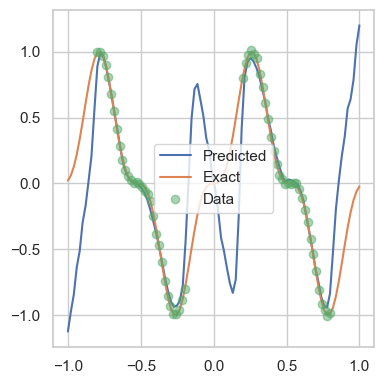

In [366]:
ax = make_plot(net, device=net.device)

In [367]:
def plot_loss_history(net):
    epochs = range(len(net.total_loss_history))

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, net.total_loss_history, label='Total Loss')
    plt.plot(epochs, net.loss_interior_history, label='Interior Loss')
    plt.plot(epochs, net.loss_data_history, label='Data Loss')
    plt.plot(epochs, net.loss_std_history, label='STD Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
#     plt.legend()
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

    plt.tight_layout()
    plt.savefig('2d_loss.png', dpi=400)  # Save the figure as a PNG file with 400 DPI
    plt.show()


def plot_loss_history_log(net):
    epochs = range(len(net.total_loss_history))

    plt.figure(figsize=(8, 6))
    plt.semilogy(epochs, net.total_loss_history, label='Total Loss')
    plt.semilogy(epochs, net.loss_interior_history, label='Interior Loss')
    plt.semilogy(epochs, net.loss_data_history, label='Data Loss')
    plt.semilogy(epochs, net.loss_std_history, label='STD Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss (log scale)')
    plt.title('Loss Over Epochs (log scale)')
#     plt.legend()
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    plt.tight_layout()
    plt.savefig('2d_log_loss.png', dpi=400)  # Save the figure as a PNG file with 400 DPI
    plt.show()

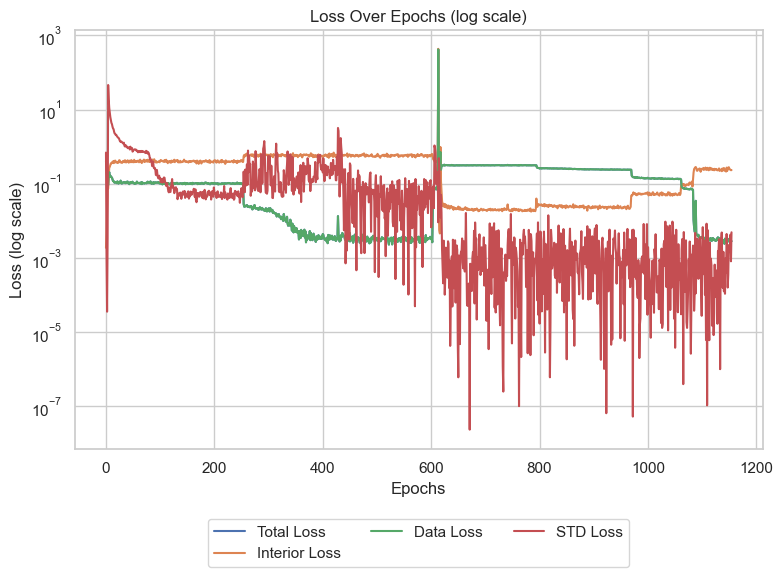

In [368]:
plot_loss_history_log(net)

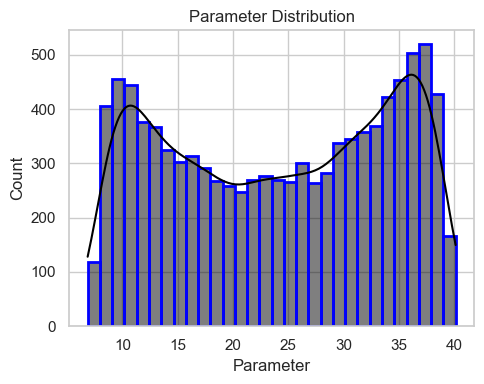

In [369]:
samples = net.sample_parameter_posterior(num_samples=10000).cpu().detach().numpy()

df = pd.DataFrame(samples, columns=['Parameter'])

plt.figure(figsize=(5, 4))  # Adjust size as needed for a single plot
sns.histplot(df['Parameter'], kde=True, linewidth=2, edgecolor='blue',
             color='black', bins =30 )
plt.title('Parameter Distribution')

plt.tight_layout()
plt.savefig("param_distribution.png", dpi=400, bbox_inches='tight')
plt.tight_layout()
plt.savefig('2d_distribution.png', dpi=400)  # Save the figure as a PNG file with 400 DPI
plt.show()

**Testing the residual plot for the whole batch of data**

In [370]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=2).fit(samples)
print(gm.means_)

[[14.92514465]
 [32.35905025]]


In [312]:
samples.mean()

22.318527

In [371]:
def forward_fixed_param(self,x, params):
        
        x = x.unsqueeze(1) if x.dim() == 1 else x


        h1 = self.act(self.b1(x))
        h2 = self.act(self.b2(h1))

        prior_param_sample = torch.rand(x.shape[0], self.hidden_size , device=self.device).requires_grad_(True)

        t1 = self.act(self.t1(prior_param_sample))
        t2 = self.act(self.t2(t1))
        posterior_param_sample = self.t3(t2)
        self.predicted_params = posterior_param_sample

        u = self.b3(torch.multiply(t2, h2))
        # u = self.b3(h2)

        return u

In [372]:
def plot_uncertainty(model, device=device):
    # Generate test data
    num_test_samples = 1000
    num_tests= 1000
    x_test = torch.linspace(-1, 1, num_test_samples, device=device)
   

    x_flat = x_test.reshape(-1)

    u_preds = []

    model.eval()
    with torch.no_grad():
        for i in range(num_tests):


            # Slice the batch
            x_batch = x_flat
   

            # Predict for this batch
            u_pred = forward_fixed_param(model, x_batch, 6.0)

            # Collect predictions
            u_preds.append(u_pred)
    

    # Concatenate all batched predictions
    u_preds = torch.stack(u_preds)
    u_mean = u_preds.mean(dim=0)
    u_std = u_preds.std(dim=0)


    # Reshape predictions to match the grid shap

    # Compute the exact solutions for comparison
    u_exact = exact_solution(x_test)


    # Compute error
    u_error = torch.abs(u_mean - u_exact)

    # Plotting
    fig, axes = plt.subplots(1, 1, figsize=(18, 10))
    axes.plot(x_test.cpu().numpy(), u_mean.cpu().numpy(), label='Predicted')
    axes.plot(x_test.cpu().numpy(), u_exact.cpu().numpy(), label='Exact')
    axes.fill_between(x_flat.cpu().numpy(), (u_mean - 2*u_std).cpu().numpy().flatten(),
                       (u_mean + 2*u_std).cpu().numpy().flatten(), alpha=0.5, label='Uncertainty')


    

Training Progress: 0epoch [00:00, ?epoch/s]


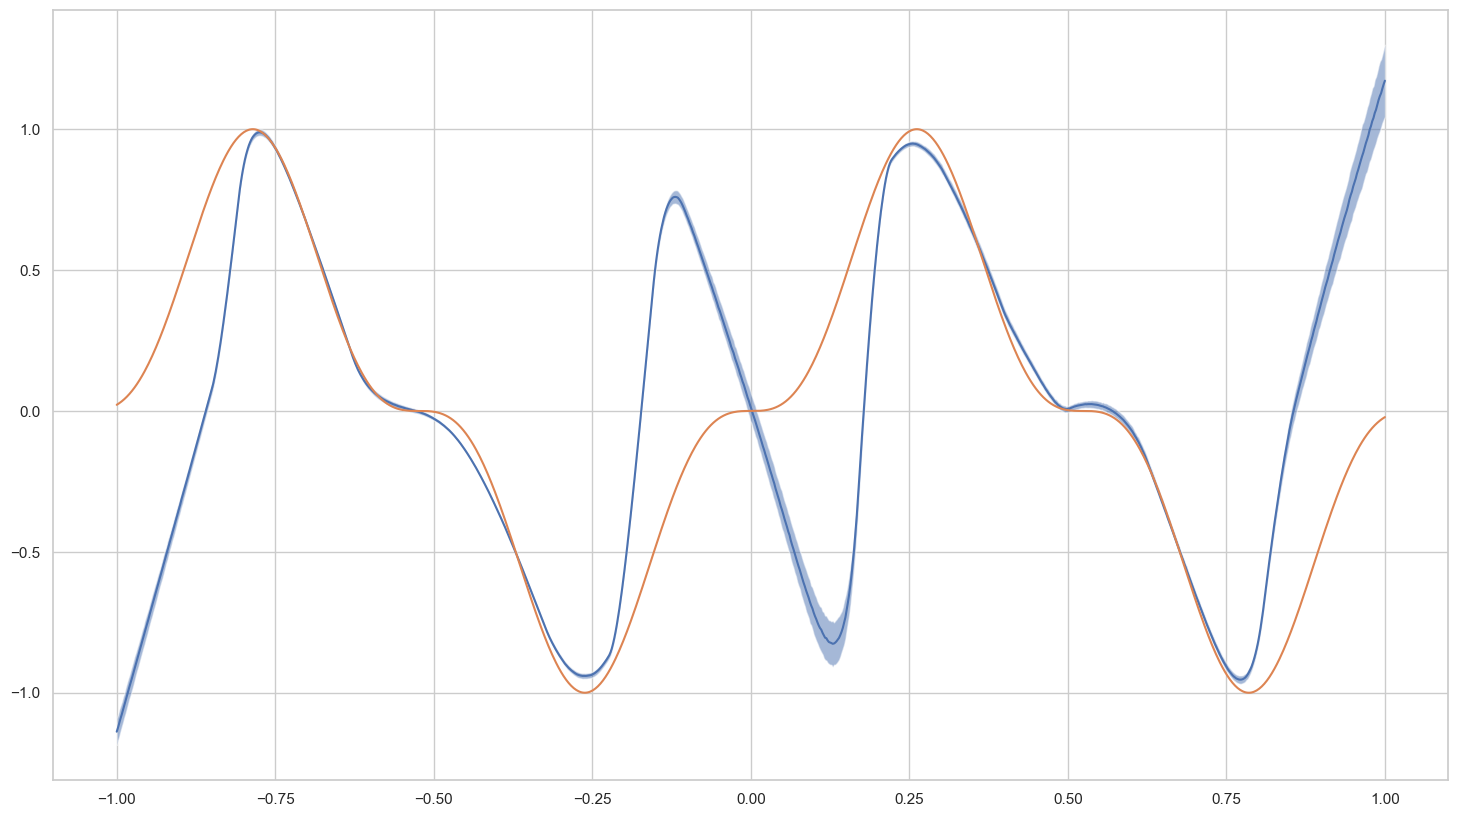

In [373]:
plot_uncertainty(net)

In [317]:
# plot_posterior_mean_errors(net)

In [293]:
torch.save({
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': net.optimizer.state_dict(),
    'total_loss_history': net.total_loss_history,
    'loss_interior_history': net.loss_interior_history,
    'loss_data_history': net.loss_data_history,
    'loss_bc_history': net.loss_bc_history,
    'loss_std_history': net.loss_std_history
    # Add other variables if needed
}, f'model_checkpoint_sin_approx.pth')